In [1]:
#1st model 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Parameters
L = 4000
hbar = 1
x0 = 200
k0_values = [0.0, 0.1, 0.2] 
E_values = np.sin(k0_values)
dt = 0.05
sigma = 20 
frames = 70000
x = np.arange(L)
dx = 1
a = 700  # Transition width
t_max = 2  
x_horizon=3000/2+a*np.arctanh(1/t_max) # Horizon position
horizon_interaction_width = 50  # Spatial width around horizon for interaction
dwell_threshold = 50  # Distance from horizon to consider "dwelling"

results = {} # Storage for results for all k0 values

In [2]:
#Main Simulation Loop for each k0
for k0 in k0_values:
    psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * k0 * (x - x0)) # Initial wavefunction
    psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))  # Normalize
    
    # Storage for current k0
    x_c_list = []  # Wave packet center
    time_list = []
    probability_list = []
    
    # Dwell time tracking
    in_dwell_region = False
    dwell_start_time = None
    dwell_end_time = None
    dwell_entries = []  # Track all entries/exits
    current_dwell_start = None
    
    # RK4 integration
    for frame in range(frames):
        current_time = frame * dt
        
        # Track wave packet center
        total_density = np.abs(psi)**2
        x_c = np.sum(x * total_density) / np.sum(total_density)
        x_c_list.append(x_c)
        time_list.append(current_time)

        # Track total probability
        total_prob = np.sum(np.abs(psi)**2) * dx
        probability_list.append(total_prob)
        
        # Track dwell time at horizon
        distance_to_horizon = abs(x_c - x_horizon)
        
        if distance_to_horizon < dwell_threshold:
            if not in_dwell_region: # Inside dwell region
                in_dwell_region = True # Just entered dwell region
                current_dwell_start = current_time
                if dwell_start_time is None:
                    dwell_start_time = current_time  # First entry
        else:
            if in_dwell_region: # Outside dwell region
                in_dwell_region = False # Just exited dwell region
                dwell_end_time = current_time  # Last exit
                if current_dwell_start is not None:
                    dwell_entries.append((current_dwell_start, current_time))
                    current_dwell_start = None
        
        
        t_norm = np.tanh((x0 - x_horizon)/a)  # normalization factor
        t = t_max * (np.tanh((x - x_horizon)/a) - t_norm) / (1 - t_norm) # Tilt profile
        alpha = 1 - t
        
        # RK4 integration
        # Stage 1: Compute k1
        dpsi_dx = np.zeros(L, dtype=complex)
        dpsi_dx[1:-1] = (psi[2:] - psi[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi[1] - psi[-1]) / (2 * dx)      # Periodic BC
        dpsi_dx[-1] = (psi[0] - psi[-2]) / (2 * dx)  
        k1 = -alpha * dpsi_dx
        
        # Stage 2: Compute k2
        psi_temp = psi + 0.5 * dt * k1
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k2 = -alpha * dpsi_dx
        
        # Stage 3: Compute k3
        psi_temp = psi + 0.5 * dt * k2
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k3 = -alpha * dpsi_dx
        
        # Stage 4: Compute k4
        psi_temp = psi + dt * k3
        dpsi_dx[1:-1] = (psi_temp[2:] - psi_temp[:-2]) / (2 * dx)
        dpsi_dx[0] = (psi_temp[1] - psi_temp[-1]) / (2 * dx)
        dpsi_dx[-1] = (psi_temp[0] - psi_temp[-2]) / (2 * dx)
        k4 = -alpha * dpsi_dx
        
        psi = psi + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4) # RK4 Update

        # Normalize occasionally
        #if frame % 100 == 0:
         #   psi /= np.sqrt(np.sum(np.abs(psi)**2 * dx))
        if frame > 0:
            dx_dt = (x_c - x_c_list[-2]) / dt if len(x_c_list) > 1 else 0
            vg_num_list.append(dx_dt)
        else:
            vg_num_list = []  # Initialize on first frame
    
    if in_dwell_region and current_dwell_start is not None: # If still in dwell region at end, close the interval
        dwell_entries.append((current_dwell_start, current_time))
    
    total_dwell_time = sum([exit_t - enter_t for enter_t, exit_t in dwell_entries]) # Calculate total dwell time from all entries
    
    # Store results for this k0
    results[k0] = {
        'x_c_list': x_c_list,
        'time_list': time_list,
        'final_psi': psi.copy(),
        'dwell_time': total_dwell_time,
        'dwell_start': dwell_start_time,
        'dwell_end': dwell_end_time,
        'dwell_entries': dwell_entries,
        'still_dwelling': in_dwell_region,
        'probability_list': probability_list,
        'vg_num': vg_num_list 
    }    

In [3]:
# Reflection/Transmission Analysis
print("Reflection/Transmission Coefficients")
colors = ['cyan', 'lime', 'magenta']
T_values = []
R_values = []
Loss_values = []

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    horizon_idx = np.argmin(np.abs(x - x_horizon)) # horizon index
    
    # Split regions at horizon
    transmission_region = x > x_horizon
    reflection_region = x < x_horizon
    
    # Calculate probabilities
    P_transmitted = np.sum(final_density[transmission_region]) * dx
    P_reflected = np.sum(final_density[reflection_region]) * dx
    P_total_final = P_transmitted + P_reflected

    P_initial = 1.0 # Initial probability (before evolution)
    
    # Proper Reflection/Transmission/Loss coefficients
    T = P_transmitted / P_initial
    R = P_reflected / P_initial
    Loss = 1.0 - (R + T)
    
    T_values.append(T)
    R_values.append(R)
    Loss_values.append(Loss)
    
    # Print results
    print(f"k0 = {k0:.1f}:")
    print(f"  Reflection (R) = {R:.6f}")
    print(f"  Transmission (T) = {T:.6f}")
    print(f"  Loss (1 - R - T) = {Loss:.6f}")
    print(f"  R + T + Loss = {R + T + Loss:.6f}")
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print()
    print(f"  Total probability (final) = {P_total_final:.6f}")
    print(f"  Expected from R+T: {R + T:.6f}")
    print(f"  Match check: {abs(P_total_final - (R+T)) < 1e-10}")
    print()

# Dwell Time Analysis
print("Dwell Time at Horizon")
print(f"Dwell threshold: ±{dwell_threshold} from horizon (x_h = {x_horizon:.2f})")
print()

dwell_times = []
for k0 in k0_values:
    dwell_time = results[k0]['dwell_time']
    dwell_start = results[k0]['dwell_start']
    dwell_end = results[k0]['dwell_end']
    dwell_entries = results[k0]['dwell_entries']
    still_dwelling = results[k0]['still_dwelling']
    dwell_times.append(dwell_time)
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Total dwell time: {dwell_time:.2f}")
    print(f"  Number of horizon passages: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for i, (enter_t, exit_t) in enumerate(dwell_entries):
            print(f"    Passage {i+1}: entered at t={enter_t:.2f}, exited at t={exit_t:.2f}, duration={exit_t-enter_t:.2f}")
    
    if dwell_start is None:
        print(f"  Never entered horizon region")
    
    if still_dwelling:
        print(f"  Still in horizon region at end of simulation")
    print()

Reflection/Transmission Coefficients
k0 = 0.0:
  Reflection (R) = 0.044319
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.955681
  R + T + Loss = 1.000000
  Total probability (final) = 0.044319

  Total probability (final) = 0.044319
  Expected from R+T: 0.044319
  Match check: True

k0 = 0.1:
  Reflection (R) = 0.112423
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.887577
  R + T + Loss = 1.000000
  Total probability (final) = 0.112423

  Total probability (final) = 0.112423
  Expected from R+T: 0.112423
  Match check: True

k0 = 0.2:
  Reflection (R) = 0.291654
  Transmission (T) = 0.000000
  Loss (1 - R - T) = 0.708346
  R + T + Loss = 1.000000
  Total probability (final) = 0.291654

  Total probability (final) = 0.291654
  Expected from R+T: 0.291654
  Match check: True

Dwell Time at Horizon
Dwell threshold: ±50 from horizon (x_h = 1884.51)

k0 = 0.0:
  Total dwell time: 522.80
  Number of horizon passages: 1
    Passage 1: entered at t=2977.15, exited at t=3499.95, d

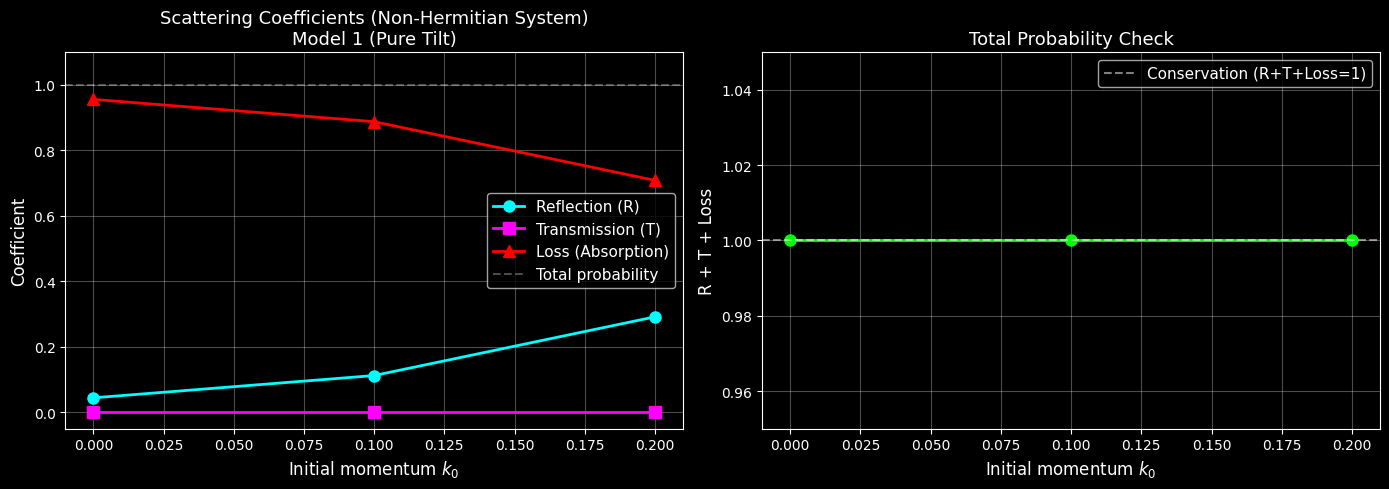

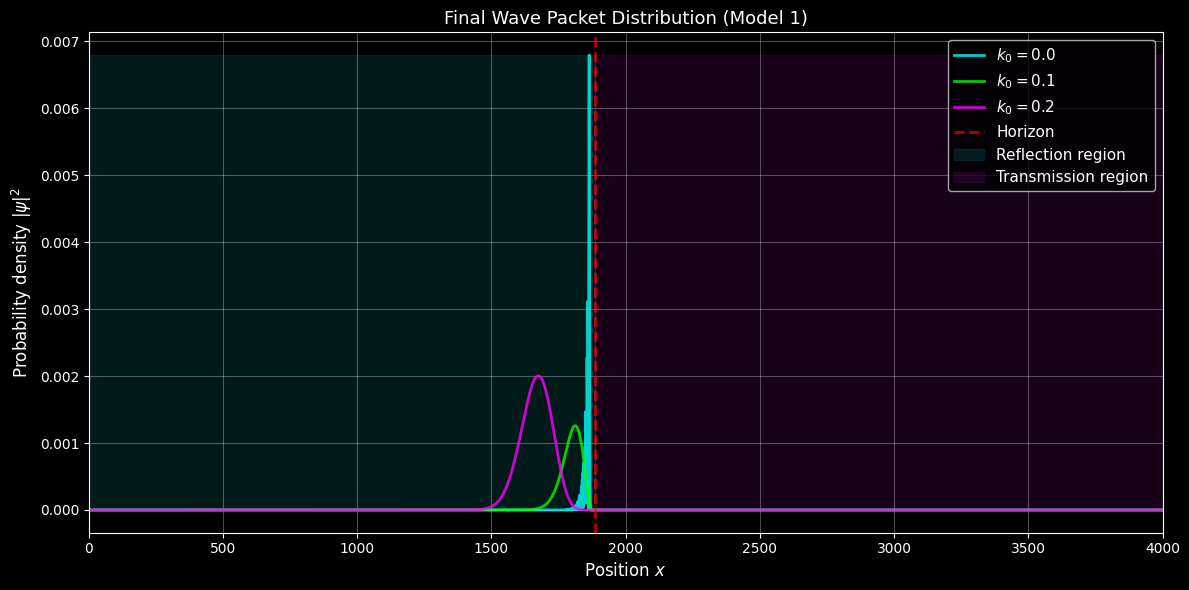

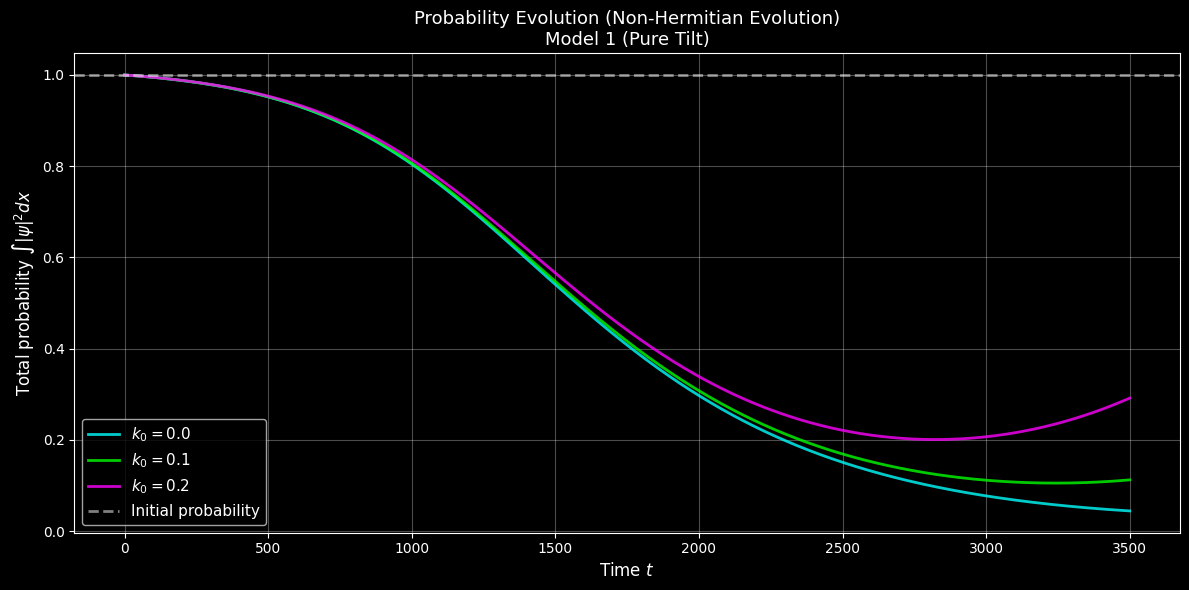

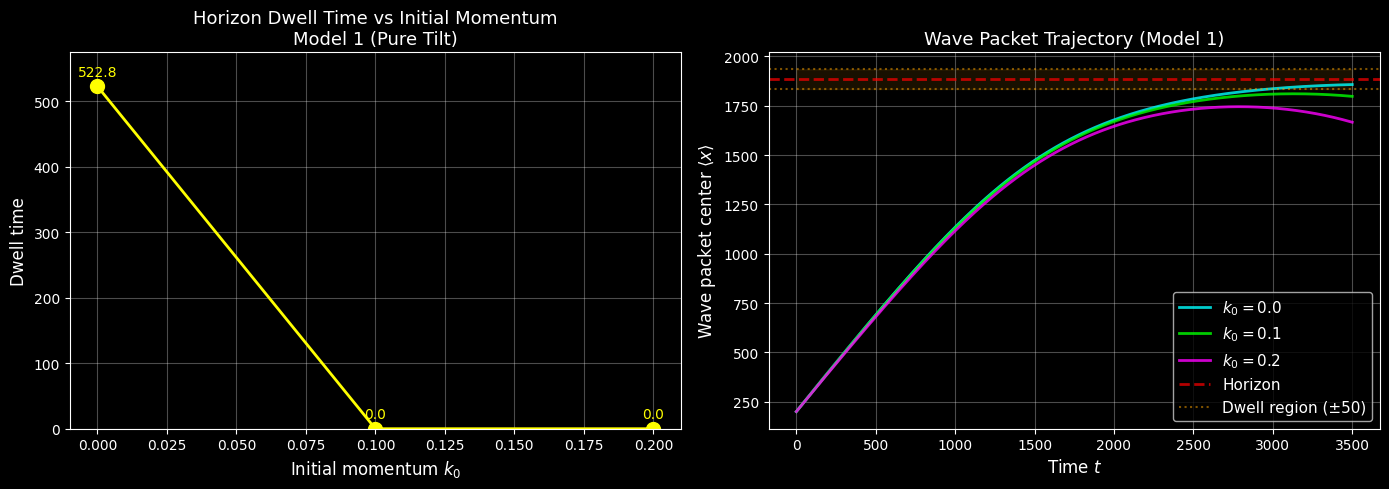

Horizon position: x_h = 1884.51
Summary
  k0 = 0.0: 95.6% absorbed
  k0 = 0.1: 88.8% absorbed
  k0 = 0.2: 70.8% absorbed


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R, T, and Loss vs k0
ax1.plot(k0_values, R_values, 'o-', color='cyan', linewidth=2, markersize=8, label='Reflection (R)')
ax1.plot(k0_values, T_values, 's-', color='magenta', linewidth=2, markersize=8, label='Transmission (T)')
ax1.plot(k0_values, Loss_values, '^-', color='red', linewidth=2, markersize=8, label='Loss (Absorption)')
ax1.axhline(y=1.0, color='white', linestyle='--', alpha=0.3, label='Total probability')
ax1.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax1.set_ylabel('Coefficient', fontsize=12)
ax1.set_title('Scattering Coefficients (Non-Hermitian System)\nModel 1 (Pure Tilt)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim([-0.05, 1.1])

# Plot 2: R + T + Loss (should equal 1)
sum_all = np.array(R_values) + np.array(T_values) + np.array(Loss_values)
ax2.plot(k0_values, sum_all, 'o-', color='lime', linewidth=2, markersize=8)
ax2.axhline(y=1.0, color='white', linestyle='--', alpha=0.5, label='Conservation (R+T+Loss=1)')
ax2.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax2.set_ylabel('R + T + Loss', fontsize=12)
ax2.set_title('Total Probability Check', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim([0.95, 1.05])

plt.tight_layout()
plt.savefig('model1_scattering_coefficients.png', dpi=150, bbox_inches='tight')
plt.show()

# Final Wavefunction Spatial Distribution
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    final_density = np.abs(results[k0]['final_psi'])**2
    ax.plot(x, final_density, color=colors[i], linewidth=2, label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon
ax.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Horizon')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], 0, x_horizon, color='cyan', alpha=0.1, label='Reflection region')
ax.fill_betweenx([0, np.max([np.max(np.abs(results[k0]['final_psi'])**2) for k0 in k0_values])], x_horizon, L, color='magenta', alpha=0.1, label='Transmission region')

ax.set_xlabel('Position $x$', fontsize=12)
ax.set_ylabel('Probability density $|\\psi|^2$', fontsize=12)
ax.set_title('Final Wave Packet Distribution (Model 1)', fontsize=13)
ax.legend(fontsize=11, loc='upper right')
ax.grid(alpha=0.3)
ax.set_xlim([0, L])

plt.tight_layout()
plt.savefig('model1_final_wavefunction.png', dpi=150, bbox_inches='tight')
plt.show()

# Probability Evolution Over Time
fig, ax = plt.subplots(figsize=(12, 6))

for i, k0 in enumerate(k0_values):
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    ax.plot(time_array, prob_array, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.axhline(y=1.0, color='white', linestyle='--', linewidth=2, alpha=0.5, label='Initial probability')
ax.set_xlabel('Time $t$', fontsize=12)
ax.set_ylabel('Total probability $\\int|\\psi|^2 dx$', fontsize=12)
ax.set_title('Probability Evolution (Non-Hermitian Evolution)\nModel 1 (Pure Tilt)', fontsize=13)
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_probability_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

# Dwell Time Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Dwell time vs k0
ax1.plot(k0_values, dwell_times, 'o-', color='yellow', linewidth=2, markersize=10)
ax1.set_xlabel('Initial momentum $k_0$', fontsize=12)
ax1.set_ylabel('Dwell time', fontsize=12)
ax1.set_title('Horizon Dwell Time vs Initial Momentum\nModel 1 (Pure Tilt)', fontsize=13)
ax1.grid(alpha=0.3)
ax1.set_ylim([0, max(dwell_times) * 1.1 if dwell_times else 1])

for i, (k0, dwell) in enumerate(zip(k0_values, dwell_times)):
    ax1.text(k0, dwell + (max(dwell_times) if dwell_times else 1)*0.03, f'{dwell:.1f}', 
             ha='center', fontsize=10, color='yellow')

# Plot 2: Trajectory showing dwell region
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    ax2.plot(time_array, x_c_array, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)

# Mark horizon and dwell region
ax2.axhline(y=x_horizon, color='red', linestyle='--', linewidth=2, 
            alpha=0.7, label='Horizon')
ax2.axhline(y=x_horizon + dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5, label=f'Dwell region (±{dwell_threshold})')
ax2.axhline(y=x_horizon - dwell_threshold, color='orange', linestyle=':', 
            linewidth=1.5, alpha=0.5)
ax2.fill_between(time_array, x_horizon - dwell_threshold, 
                  x_horizon + dwell_threshold, color='orange', alpha=0.1)

ax2.set_xlabel('Time $t$', fontsize=12)
ax2.set_ylabel('Wave packet center $\\langle x \\rangle$', fontsize=12)
ax2.set_title('Wave Packet Trajectory (Model 1)', fontsize=13)
ax2.legend(fontsize=11, loc='best')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_dwell_time.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Horizon position: x_h = {x_horizon:.2f}")
print("Summary")
for k0, loss in zip(k0_values, Loss_values):
    print(f"  k0 = {k0:.1f}: {loss*100:.1f}% absorbed")

In [5]:
#Absorption Rate Analysis
print("Absorption Rate Analysis")

all_dP_dt = {} # Storage for all k0 data

for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    dP_dt = np.gradient(prob_array, time_array)  # Compute dP/dt numerically
    all_dP_dt[k0] = dP_dt
    
    # Find maximum absorption rate (most negative dP/dt)
    max_abs_rate_idx = np.argmin(dP_dt)
    max_abs_rate = dP_dt[max_abs_rate_idx]
    t_max_abs = time_array[max_abs_rate_idx]
    
    # Average absorption rate during dwell
    dwell_entries = results[k0]['dwell_entries']
    if len(dwell_entries) > 0:
        t_in, t_out = dwell_entries[0]
        dwell_mask = (time_array >= t_in) & (time_array <= t_out)
        avg_dwell_rate = np.mean(dP_dt[dwell_mask])
    else:
        avg_dwell_rate = 0
        t_in = None
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Maximum absorption rate: {max_abs_rate:.6f} at t = {t_max_abs:.1f}")
    if t_in is not None:
        print(f"  Average rate during dwell: {avg_dwell_rate:.6f}")
    else:
        print(f"  Never entered dwell region (turned before horizon)")
    print()

Absorption Rate Analysis
k0 = 0.0:
  Maximum absorption rate: -0.000565 at t = 1415.9
  Average rate during dwell: -0.000067

k0 = 0.1:
  Maximum absorption rate: -0.000557 at t = 1416.1
  Never entered dwell region (turned before horizon)

k0 = 0.2:
  Maximum absorption rate: -0.000534 at t = 1416.9
  Never entered dwell region (turned before horizon)



Closest Approach to Horizon Analysis
k0 = 0.0:
  Closest approach: x = 1857.0 at t = 3500
  Distance from horizon: Δx = 27.6
  Probability at closest: P = 0.044321
  Loss during approach: 95.6%
  Max loss at: x = 1425.5, t = 1416
  → Reached horizon region

k0 = 0.1:
  Closest approach: x = 1810.2 at t = 3132
  Distance from horizon: Δx = 74.3
  Probability at closest: P = 0.106609
  Loss during approach: 89.3%
  Max loss at: x = 1419.7, t = 1416
  → Turned before horizon

k0 = 0.2:
  Closest approach: x = 1744.9 at t = 2787
  Distance from horizon: Δx = 139.7
  Probability at closest: P = 0.201066
  Loss during approach: 79.9%
  Max loss at: x = 1402.3, t = 1417
  → Turned before horizon

Maximum Absorption Locations
k0 = 0.0:
  Position of max absorption: x = 1425.5
  Distance from horizon: Δx = 459.0
  Tilt at this point: V(x) = 0.412
  Group velocity: v_g(x) = 0.588
  Loss rate: dP/dt = -0.000565
  → Absorption BEFORE horizon region

k0 = 0.1:
  Position of max absorption: x = 1419

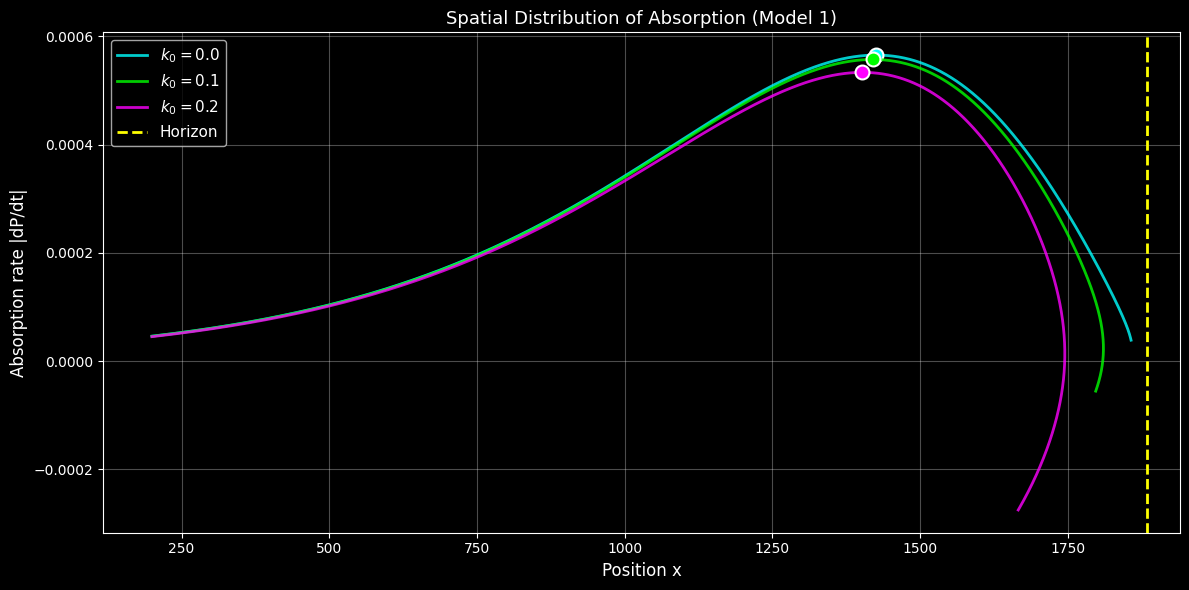

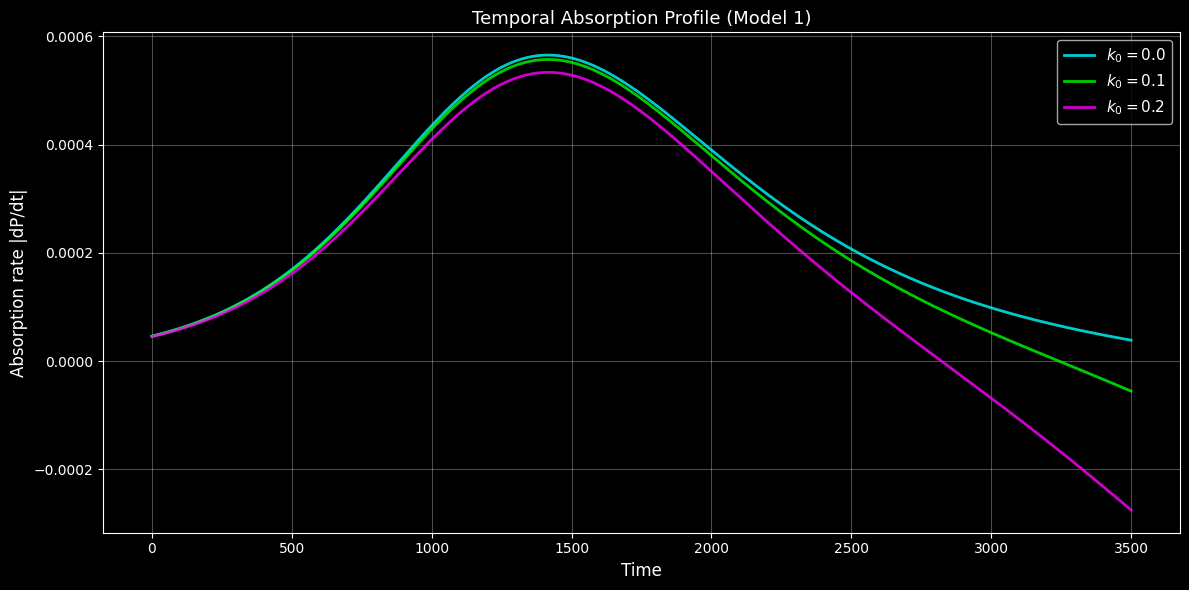

In [6]:
print("Closest Approach to Horizon Analysis")
for k0 in k0_values:
    x_c_array = np.array(results[k0]['x_c_list'])
    time_array = np.array(results[k0]['time_list'])
    prob_array = np.array(results[k0]['probability_list'])
    
    # Find closest approach to horizon
    closest_idx = np.argmin(np.abs(x_c_array - x_horizon))
    t_closest = time_array[closest_idx]
    x_closest = x_c_array[closest_idx]
    P_at_closest = prob_array[closest_idx]
    distance_to_horizon = abs(x_horizon - x_closest)
    
    # Find maximum absorption rate location
    dP_dt = all_dP_dt[k0]
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Closest approach: x = {x_closest:.1f} at t = {t_closest:.0f}")
    print(f"  Distance from horizon: Δx = {distance_to_horizon:.1f}")
    print(f"  Probability at closest: P = {P_at_closest:.6f}")
    print(f"  Loss during approach: {(1-P_at_closest)*100:.1f}%")
    print(f"  Max loss at: x = {x_max_loss:.1f}, t = {t_max_loss:.0f}")
    
    if distance_to_horizon < dwell_threshold:
        print(f"  → Reached horizon region")
    else:
        print(f"  → Turned before horizon")
    print()

print("Maximum Absorption Locations")
for k0 in k0_values:
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    
    # Key moments
    max_loss_idx = np.argmin(dP_dt)
    t_max_loss = time_array[max_loss_idx]
    x_max_loss = x_c_array[max_loss_idx]
    P_max_loss = prob_array[max_loss_idx]
    
    # Tilt at maximum loss position
    V_norm = np.tanh((x0 - x_horizon)/a)
    V_max_loss = t_max * (np.tanh((x_max_loss - x_horizon)/a) - V_norm) / (1 - V_norm)
    v_g_max_loss = 1 - V_max_loss
    
    print(f"k0 = {k0:.1f}:")
    print(f"  Position of max absorption: x = {x_max_loss:.1f}")
    print(f"  Distance from horizon: Δx = {x_horizon - x_max_loss:.1f}")
    print(f"  Tilt at this point: V(x) = {V_max_loss:.3f}")
    print(f"  Group velocity: v_g(x) = {v_g_max_loss:.3f}")
    print(f"  Loss rate: dP/dt = {dP_dt[max_loss_idx]:.6f}")
    
    if x_max_loss < x_horizon - dwell_threshold:
        print(f"  → Absorption BEFORE horizon region")
    elif abs(x_max_loss - x_horizon) <= dwell_threshold:
        print(f"  → Absorption AT horizon region")
    else:
        print(f"  → Absorption DURING/AFTER reflection")
    print()

# Loss rate vs position for all k0
fig, ax = plt.subplots(figsize=(12, 6))
for i, k0 in enumerate(k0_values):
    x_c_array = np.array(results[k0]['x_c_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(x_c_array, -dP_dt, color=colors[i], linewidth=2, 
             label=f'$k_0 = {k0:.1f}$', alpha=0.8)
    
    # Mark maximum absorption point
    max_loss_idx = np.argmin(dP_dt)
    x_max = x_c_array[max_loss_idx]
    rate_max = -dP_dt[max_loss_idx]
    ax.plot(x_max, rate_max, 'o', color=colors[i], markersize=10, 
             markeredgecolor='white', markeredgewidth=1.5)

ax.axvline(x_horizon, color='yellow', linestyle='--', linewidth=2, label='Horizon')
ax.set_xlabel('Position x', fontsize=12)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=12)
ax.set_title('Spatial Distribution of Absorption (Model 1)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_absorption_comparison_all_k0.png', dpi=150)
plt.show()

# dP/dt vs time
fig, ax = plt.subplots(figsize=(12, 6))
for i, k0 in enumerate(k0_values):
    time_array = np.array(results[k0]['time_list'])
    dP_dt = all_dP_dt[k0]
    ax.plot(time_array, -dP_dt, color=colors[i], linewidth=2, 
            label=f'$k_0 = {k0:.1f}$', alpha=0.8)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Absorption rate |dP/dt|', fontsize=12)
ax.set_title('Temporal Absorption Profile (Model 1)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_absorption_vs_time.png', dpi=150)
plt.show()

In [7]:
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            # Find probability at dwell entry and exit
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            
            print(f"k0 = {k0:.1f}, Dwell period {j+1}:")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f}")
            if P_out > P_in:
                print(f"  ⚠️ Probability GREW during dwell (unphysical!)")

# Check all three k0 values
for k0 in k0_values:
    dwell_entries = results[k0]['dwell_entries']
    prob_array = np.array(results[k0]['probability_list'])
    time_array = np.array(results[k0]['time_list'])
    
    print(f"\n===== k0 = {k0:.1f} =====")
    print(f"Number of dwell periods: {len(dwell_entries)}")
    
    if len(dwell_entries) > 0:
        for j, (t_in, t_out) in enumerate(dwell_entries):
            idx_in = np.argmin(np.abs(time_array - t_in))
            idx_out = np.argmin(np.abs(time_array - t_out))
            P_in = prob_array[idx_in]
            P_out = prob_array[idx_out]
            duration = t_out - t_in
            
            print(f"Dwell period {j+1}:")
            print(f"  Duration: {duration:.0f}")
            print(f"  Entry: t={t_in:.0f}, P={P_in:.6f}")
            print(f"  Exit: t={t_out:.0f}, P={P_out:.6f}")
            print(f"  Change: ΔP = {P_out - P_in:+.6f} ({(P_out/P_in - 1)*100:+.1f}%)")
    else:
        print("  No dwell periods detected")

k0 = 0.0, Dwell period 1:
  Entry: t=2977, P=0.079531
  Exit: t=3500, P=0.044321
  Change: ΔP = -0.035210

===== k0 = 0.0 =====
Number of dwell periods: 1
Dwell period 1:
  Duration: 523
  Entry: t=2977, P=0.079531
  Exit: t=3500, P=0.044321
  Change: ΔP = -0.035210 (-44.3%)

===== k0 = 0.1 =====
Number of dwell periods: 0
  No dwell periods detected

===== k0 = 0.2 =====
Number of dwell periods: 0
  No dwell periods detected



GROUP VELOCITY DIAGNOSTIC ANALYSIS - MODEL 1

--- Analysis for k0 = 0.0 ---
Approach Region (x < 1835):
  Mean v_g = 0.549028 ± 0.331292
  Range: 0.070071 to 0.999335
  Time spent: 2977.05
Horizon Region (x = 1884.5143010338384 ± 50):
  Mean v_g = 0.042938 ± 0.014829
  Minimum v_g = 0.018028
  Range: 0.018028 to 0.070065
  Time spent: 522.80
  → SLOWS near horizon (min v_g = 0.018028)
Scattering Results:
  Reflection: R = 0.0443
  Transmission: T = 0.0000
  Loss: L = 0.9557
  → WEAK REFLECTION (R < 50%)

--- Analysis for k0 = 0.1 ---
Approach Region (x < 1835):
  Mean v_g = 0.456346 ± 0.370022
  Range: -0.071839 to 0.994343
  Time spent: 3499.90
Never entered horizon region (turned before reaching it)
Scattering Results:
  Reflection: R = 0.1124
  Transmission: T = 0.0000
  Loss: L = 0.8876
  → WEAK REFLECTION (R < 50%)

--- Analysis for k0 = 0.2 ---
Approach Region (x < 1835):
  Mean v_g = 0.418877 ± 0.400422
  Range: -0.232126 to 0.979415
  Time spent: 3499.90
Never entered horizon 

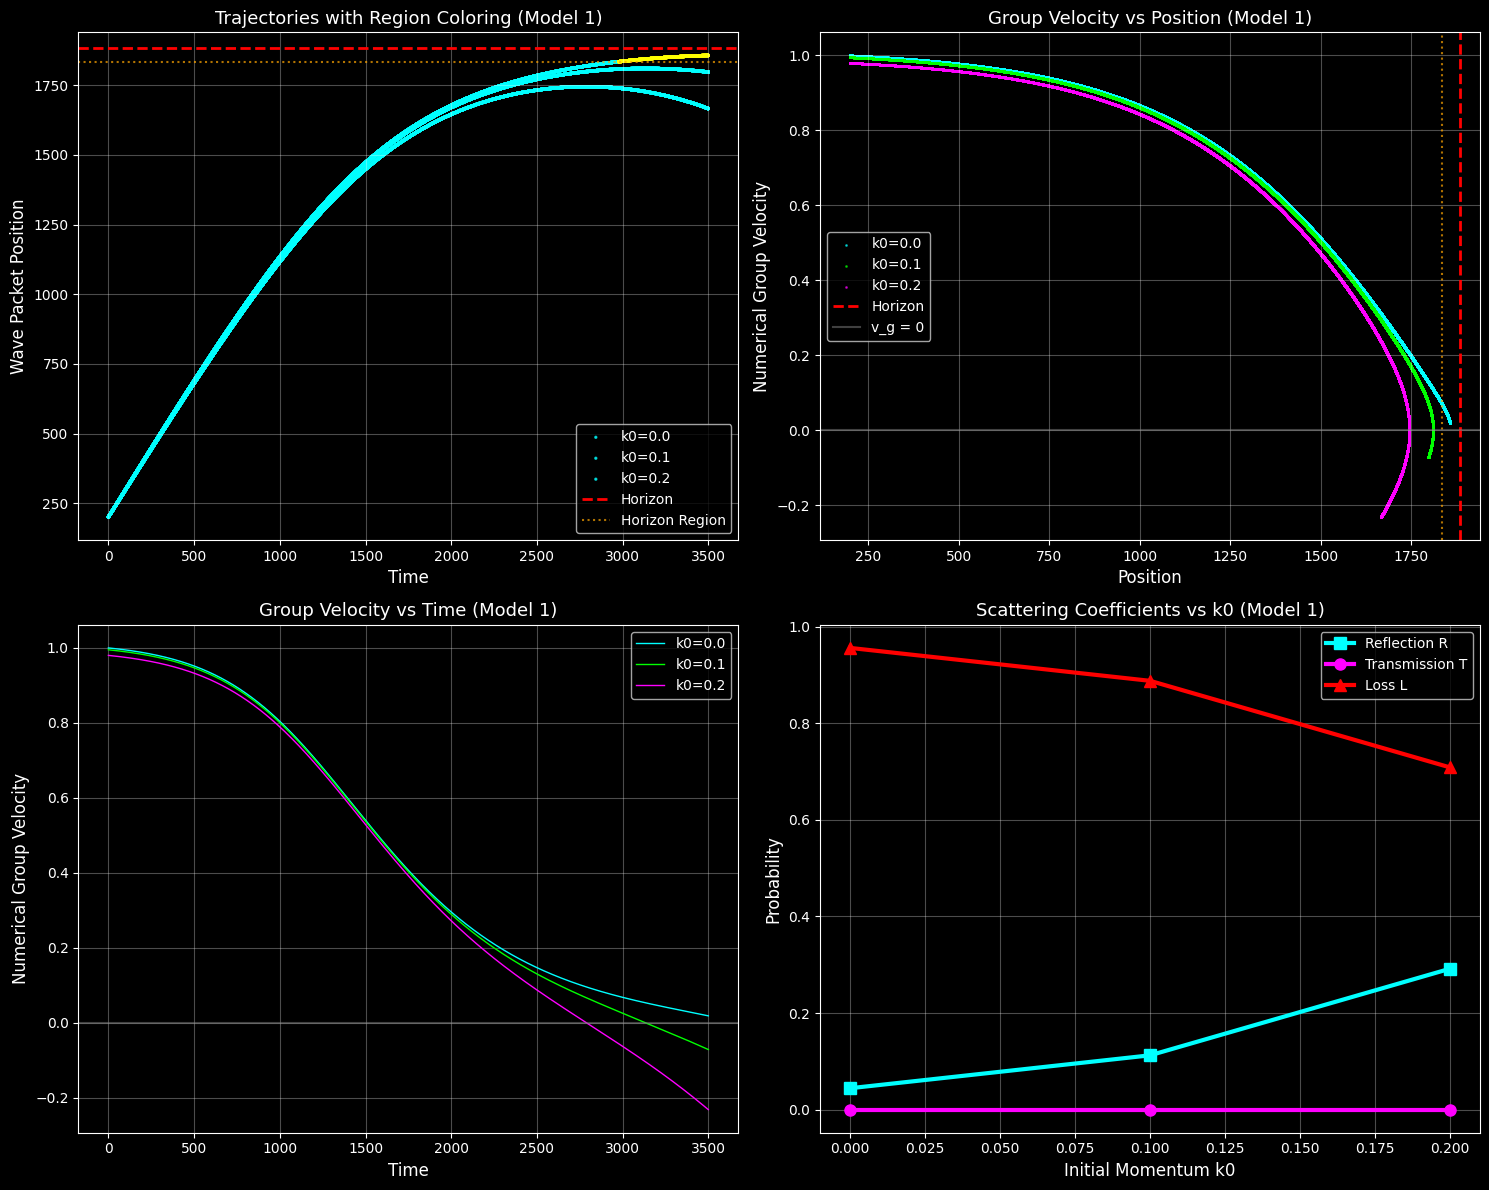


SUMMARY OF KEY FINDINGS - MODEL 1:
Horizon position: x = 1884.5
Horizon region: x = 1884.5143010338384 ± 50

Scattering behavior:
k0 = 0.0: R = 0.0443, T = 0.0000, Loss = 0.9557
k0 = 0.1: R = 0.1124, T = 0.0000, Loss = 0.8876
k0 = 0.2: R = 0.2917, T = 0.0000, Loss = 0.7083


In [8]:
#Group Velocity Diagnostic Analysis - Model 1
print("\n" + "="*60)
print("GROUP VELOCITY DIAGNOSTIC ANALYSIS - MODEL 1")
print("="*60)

for i, k0 in enumerate(k0_values):
    print(f"\n--- Analysis for k0 = {k0} ---")
    
    # Get numerical trajectory data
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    vg_num_list = results[k0]['vg_num']
    
    # Define regions (Model 1: focus on approach and reflection)
    horizon_region = (x_horizon - horizon_interaction_width, x_horizon + horizon_interaction_width)
    approach_region = (0, x_horizon - horizon_interaction_width)
    
    # Analyze group velocity in each region
    vg_approach = []
    vg_horizon = [] 
    times_approach = []
    times_horizon = []
    
    for j, (x_pos, time_val) in enumerate(zip(x_c_list[1:], time_list[1:])):
        if j < len(vg_num_list):
            vg = vg_num_list[j]
            
            if approach_region[0] <= x_pos <= approach_region[1]:
                vg_approach.append(vg)
                times_approach.append(time_val)
            elif horizon_region[0] <= x_pos <= horizon_region[1]:
                vg_horizon.append(vg)
                times_horizon.append(time_val)
    
    # Calculate statistics
    if vg_approach:
        vg_approach_mean = np.mean(vg_approach)
        vg_approach_std = np.std(vg_approach)
        print(f"Approach Region (x < {x_horizon-horizon_interaction_width:.0f}):")
        print(f"  Mean v_g = {vg_approach_mean:.6f} ± {vg_approach_std:.6f}")
        print(f"  Range: {min(vg_approach):.6f} to {max(vg_approach):.6f}")
        print(f"  Time spent: {max(times_approach)-min(times_approach) if times_approach else 0:.2f}")
    
    if vg_horizon:
        vg_horizon_mean = np.mean(vg_horizon)
        vg_horizon_std = np.std(vg_horizon)
        vg_horizon_min = min(vg_horizon)
        print(f"Horizon Region (x = {x_horizon} ± {horizon_interaction_width}):")
        print(f"  Mean v_g = {vg_horizon_mean:.6f} ± {vg_horizon_std:.6f}")
        print(f"  Minimum v_g = {vg_horizon_min:.6f}")
        print(f"  Range: {min(vg_horizon):.6f} to {max(vg_horizon):.6f}")
        print(f"  Time spent: {max(times_horizon)-min(times_horizon) if times_horizon else 0:.2f}")
        
        # Check if wave packet stops or reflects
        if abs(vg_horizon_min) < 1e-3:
            print(f"  → FREEZES at horizon (v_g ≈ {vg_horizon_min:.6f})")
        elif vg_horizon_min < 0:
            print(f"  → REFLECTS from horizon (v_g changes sign)")
        else:
            print(f"  → SLOWS near horizon (min v_g = {vg_horizon_min:.6f})")
    else:
        print(f"Never entered horizon region (turned before reaching it)")
    
    # Reflection analysis
    T = T_values[i]
    R = R_values[i]
    Loss = Loss_values[i]
    print(f"Scattering Results:")
    print(f"  Reflection: R = {R:.4f}")
    print(f"  Transmission: T = {T:.4f}")
    print(f"  Loss: L = {Loss:.4f}")
    
    if R > 0.9:
        print(f"  → STRONG REFLECTION (R > 90%)")
    elif R > 0.5:
        print(f"  → PARTIAL REFLECTION (50% < R < 90%)")
    else:
        print(f"  → WEAK REFLECTION (R < 50%)")

# ===== Plot Group Velocity Analysis =====
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Trajectories with region coloring (approach/horizon only)
ax1 = axes[0, 0]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list']
    time_list = results[k0]['time_list']
    
    # Color code by region (only approach and horizon for Model 1)
    colors_regions = []
    for x_pos in x_c_list:
        if x_pos < x_horizon - horizon_interaction_width:
            colors_regions.append('cyan')  # Approach
        else:
            colors_regions.append('yellow')  # Horizon region
    
    ax1.scatter(time_list, x_c_list, c=colors_regions, s=2, alpha=0.7, label=f'k0={k0}')
    
ax1.axhline(y=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax1.axhline(y=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7, label='Horizon Region')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Wave Packet Position', fontsize=12)
ax1.set_title('Trajectories with Region Coloring (Model 1)', fontsize=13)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Group velocity vs position
ax2 = axes[0, 1]
for i, k0 in enumerate(k0_values):
    x_c_list = results[k0]['x_c_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(x_c_list):
        ax2.scatter(x_c_list, vg_num_list, color=colors[i], s=1, alpha=0.6, label=f'k0={k0}')
    
ax2.axvline(x=x_horizon, color='red', linestyle='--', linewidth=2, label='Horizon')
ax2.axvline(x=x_horizon - horizon_interaction_width, color='orange', linestyle=':', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5, label='v_g = 0')
ax2.set_xlabel('Position', fontsize=12)
ax2.set_ylabel('Numerical Group Velocity', fontsize=12)
ax2.set_title('Group Velocity vs Position (Model 1)', fontsize=13)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Group velocity vs time
ax3 = axes[1, 0]
for i, k0 in enumerate(k0_values):
    time_list = results[k0]['time_list'][1:]  # Skip first point
    vg_num_list = results[k0]['vg_num']
    
    if len(vg_num_list) == len(time_list):
        ax3.plot(time_list, vg_num_list, color=colors[i], linewidth=1, label=f'k0={k0}')
    
ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Numerical Group Velocity', fontsize=12)
ax3.set_title('Group Velocity vs Time (Model 1)', fontsize=13)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Scattering coefficients vs initial momentum
ax4 = axes[1, 1]
ax4.plot(k0_values, R_values, 's-', color='cyan', linewidth=3, markersize=8, label='Reflection R')
ax4.plot(k0_values, T_values, 'o-', color='magenta', linewidth=3, markersize=8, label='Transmission T')
ax4.plot(k0_values, Loss_values, '^-', color='red', linewidth=3, markersize=8, label='Loss L')
ax4.set_xlabel('Initial Momentum k0', fontsize=12)
ax4.set_ylabel('Probability', fontsize=12)
ax4.set_title('Scattering Coefficients vs k0 (Model 1)', fontsize=13)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('model1_group_velocity_diagnostics.png', dpi=150)
plt.show()

print("\n" + "="*60)
print("SUMMARY OF KEY FINDINGS - MODEL 1:")
print("="*60)
print(f"Horizon position: x = {x_horizon:.1f}")
print(f"Horizon region: x = {x_horizon} ± {horizon_interaction_width}")
print("\nScattering behavior:")

for i, k0 in enumerate(k0_values):
    print(f"k0 = {k0}: R = {R_values[i]:.4f}, T = {T_values[i]:.4f}, Loss = {Loss_values[i]:.4f}")